# Data analysis 4 - Lecture 3

This lecture is about introduction to CNNs.

We use validating sets, and evaluate our models on CIFAR-10 dataset.

Also we will try the TransferLearning simple/educational example where we use one model trained on a dataset and retrained only the final layer for different dataset.


TODO:
[Open in Google colab](https://colab.research.google.com/github/jplatos/2019-2020-da4/blob/master/ds4_02.ipynb)
[Download from Github](https://raw.githubusercontent.com/jplatos/2019-2020-DA4/master/ds4_02.ipynb)


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from tensorflow.compat.v1.keras import backend as K #for computing tensors directly
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals

tf.version.VERSION

'2.1.0'

# Defining terms for CNN

## Convolution
A convolution is defined as the integral of the product of the two functions after one is reversed and shifted. It is a mathmematical way how to analyze behavior of the functions and the relation between the functions.

In image processing, **kernel** or **convolution matrix** or **mask** is a small matrix. In general the convolution in image processing is defined as:

$$g(x, y) = \omega * f(x,y) = \sum_{s=-a}^{a}\sum_{t=-b}^{b}\omega(s,t)f(x-s, y-t)$$

where $g(x,y)$ is filtered image, $f(x,y)$ is original image, $\omega$ if the filter kernel. 

A kernel (also called a filter) is a smaller-sized matrix in comparison to the dimensions of the input image, that consists of real valued entries.

![Example of the Convolution](https://raw.githubusercontent.com/jplatos/2019-2020-DA4/master/images/convolution_example.gif)

### Example filters

|Name|Definition|
|----|:--------:|
|Identity| $\left[\begin{matrix}0&0&0\\0&1&0\\0&0&0\end{matrix}\right]$|
|Sobel vertical edge detection| $\left[\begin{matrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{matrix}\right]$|
|Sobel horizontal edge detection| $\left[\begin{matrix}+1&+2&+1\\0&0&0\\-1&-2&-1\end{matrix}\right]$|
|Edge detection| $\left[\begin{matrix}-1&-1&-1\\-1&8&-1\\-1&-1&-1\end{matrix}\right]$|
|Sharpen| $\left[\begin{matrix}0&-1&0\\-1&5&-1\\0&-1&0\end{matrix}\right]$|
|Uniform blur|$\frac{1}{9}\left[\begin{matrix}1&1&1\\1&1&1\\1&1&1\end{matrix}\right]$|
|Gaussian blur 3x3| $\frac{1}{16}\left[\begin{matrix}1&2&1\\2&4&2\\1&2&1\end{matrix}\right]$|


## Padding

One tricky issue when applying convolutional is losing pixels on the edges of our image. A straightforward solution to this problem is to add extra pixels around the boundary of our input image, which increases the effective size of the image.

![Padding example](https://raw.githubusercontent.com/jplatos/2019-2020-DA4/master/images/padding_example.png)

### Practical example of convolution and padding without TF

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

lena_img_url = 'https://raw.githubusercontent.com/jplatos/2019-2020-DA4/master/images/lena.png'
img = rgb2gray(mpimg.imread(lena_img_url))
img = img/255.0
img.shape

In [ ]:
plt.imshow(img, cmap='gray')

In [ ]:
blur_mask = np.ones((3,3))/9.0
mask = np.array([
    [ 0,-1, 0],
    [-1, 4,-1],
    [ 0,-1, 0]
    ]) 

img_blur = convolve2d(img, blur_mask, boundary='symm', mode='same')
result = np.clip(convolve2d(img_blur, mask, boundary='symm', mode='same'), 0, 1)

plt.imshow(result, cmap='gray')

## Pooling

Pooling is a way how to decrease the amount of information transfered from one layer to another.
The standard way ho to do it is Average Pooling and Maximum Pooling.

![MaxPooling example](https://raw.githubusercontent.com/jplatos/2019-2020-DA4/master/images/pooling_example.png)

## Tensorflow implementation of the Convolution Neural Network

### Some utility functions
Here is some functions we will use later several times
* **show_history** - show history of the **fit** method


In [2]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i][0]])
    plt.show()

#### Dataset load
Importing dataset **CIFAR10** a collection of images 28x28 grayscale of typical clothes and accesories.
Dataset is:
* downloaded
* splitted into train and test set
* converted from the range <0,255> into <0, 1>
* *train* is splitted into *train* and *validation* set 
* class names are defined

In [4]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

# train_x = train_x/255.0
# test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)
print('Class count:', class_count, class_names)


Train data shape:  (40000, 32, 32, 3) (40000, 1)
Validation data shape:  (10000, 32, 32, 3) (10000, 1)
Test data shape:   (10000, 32, 32, 3) (10000, 1)
Class count: 10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Show example images of the dataset

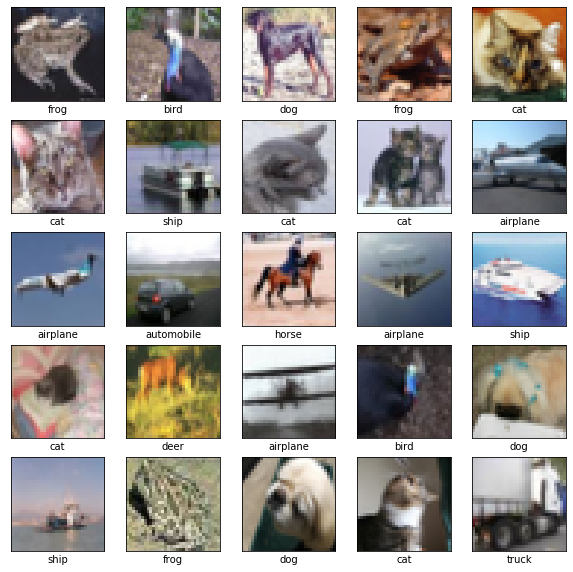

In [5]:
show_example(train_x, train_y, class_names)

#### Definition of the model
The base model is defined as *Sequential* with 2 convolutional layers.

Summarization of the model and compilation is done similarly as well.

In [6]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_count)
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 16)        4624      
_________________________________________________________________
flatten (Flatten)            (None, 2704)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                173120    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 179,290
Trainable params: 179,290
Non-trainable params: 0
__________________________________________________

#### Fit the model for defined number of epochs.
Show the history of learning, evaluate the efficiency of the model.

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 23s 564us/sample - loss: 2.2026 - accuracy: 0.2300 - val_loss: 1.7611 - val_accuracy: 0.3391
Epoch 2/5
40000/40000 [==============================] - 24s 604us/sample - loss: 1.6419 - accuracy: 0.3937 - val_loss: 1.5395 - val_accuracy: 0.4282
Epoch 3/5
40000/40000 [==============================] - 26s 650us/sample - loss: 1.4246 - accuracy: 0.4861 - val_loss: 1.4444 - val_accuracy: 0.4792
Epoch 4/5
40000/40000 [==============================] - 27s 669us/sample - loss: 1.2604 - accuracy: 0.5494 - val_loss: 1.3839 - val_accuracy: 0.5126
Epoch 5/5
10000/10000 [==============================] - 2s 175us/sample - loss: 1.3933 - accuracy: 0.5221
Test accuracy:  0.5221


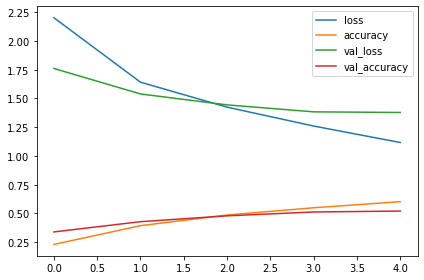

In [7]:
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=5)

show_history(history)

test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

#### Vizualization of the confusion matrix.

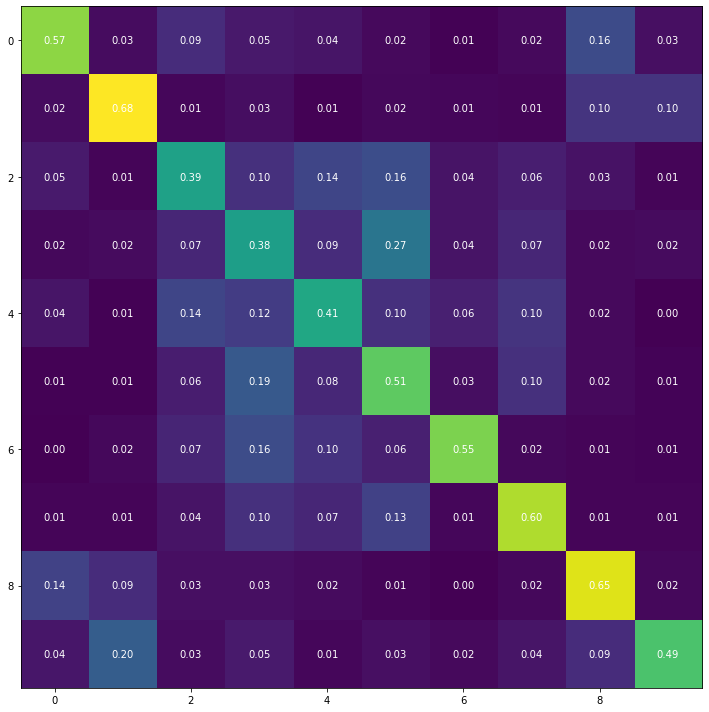

In [8]:
predictions = model.predict(test_x)
conf_matrix = np.zeros((class_count, class_count))
for idx, pred in enumerate(predictions):
    row = test_y[idx]
    col = np.argmax(pred)
    conf_matrix[row, col] += 1

# print(conf_matrix)
conf_matrix = normalize(conf_matrix, axis=1, norm='l1')
# print(conf_matrix)

plt.figure(figsize=(class_count,class_count))

plt.imshow(conf_matrix)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = plt.text(j, i, "{:.2f}".format(conf_matrix[i, j]), ha="center", va="center", color="w")

plt.tight_layout()
plt.show()     

## Tasks for Lecture 
1. [Data augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) is used to expand the training dataset in order to improve the performance and ability of the model to generalize.
2. Desing a model which will be able to classify **CIFAR10** with accuracy higher than **90%**.